In [1]:
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from scipy.stats import logistic
from scipy.special import logit

import torch
import torch.nn.functional as F
from torchvision import transforms
from torch.utils.data import Dataset
from torch.cuda.amp import autocast, GradScaler

if torch.cuda.is_available():
    device = torch.device('cuda')
    print("Train with GPU support.")
else:
    device = torch.device('cpu')
    print("No GPU found, train with CPU support.")

import numpy as np
import json
import pandas as pd
import matplotlib.pyplot as plt


# own utils
from utils.graph import *
from utils.tram_models import *
from utils.tram_model_helpers import *
from utils.tram_data import *
from utils.continous import *
from utils.sampling_tram_data import *

Train with GPU support.


In [2]:
def dgp(n_obs=10000, n_vars=10, seed=None):
    """
    Generate a synthetic dataset with n_vars variables and n_obs observations,
    where each variable contains a constant value: x2 = 2, x3 = 3, ..., x{n_vars+1} = n_vars+1.

    Args:
        n_obs (int): Number of observations (rows).
        n_vars (int): Number of variables (columns).
        seed (int or None): Random seed (not used here since data is deterministic).

    Returns:
        pd.DataFrame: Generated dataset.
    """
    values = np.arange(2, 2 + n_vars)/10  # [2, 3, ..., n_vars + 1]
    data = np.tile(values, (n_obs, 1))  # Repeat each value across n_obs rows
    columns = [f"x{i+2}" for i in range(n_vars)]
    df = pd.DataFrame(data, columns=columns)
    return df

In [3]:
df = dgp(n_obs=100, n_vars=10, seed=42)
# Get min_vals and max_vals as torch tensors
quantiles = df.quantile([0.025, 0.975])
min_vals = quantiles.loc[0.025].values.astype(np.float32)
max_vals = quantiles.loc[0.975].values.astype(np.float32)

print(df.head())

    x2   x3   x4   x5   x6   x7   x8   x9  x10  x11
0  0.2  0.3  0.4  0.5  0.6  0.7  0.8  0.9  1.0  1.1
1  0.2  0.3  0.4  0.5  0.6  0.7  0.8  0.9  1.0  1.1
2  0.2  0.3  0.4  0.5  0.6  0.7  0.8  0.9  1.0  1.1
3  0.2  0.3  0.4  0.5  0.6  0.7  0.8  0.9  1.0  1.1
4  0.2  0.3  0.4  0.5  0.6  0.7  0.8  0.9  1.0  1.1


In [4]:
# train
train_df, temp_df = train_test_split(df, test_size=0.2, random_state=42)
# Validation and test
val_df, test_df = train_test_split(temp_df, test_size=0.5, random_state=42)

print(f"Train size: {len(train_df)}, Validation size: {len(val_df)}, Test size: {len(test_df)}")

Train size: 80, Validation size: 10, Test size: 10


In [5]:
## new fucnitons for multinput ci etc
from collections import defaultdict

def create_nn_model_names(adj_matrix, data_type):
    """
    Returns the model names for the NN models based on the adj_matrix and data_type.
    Supports extended codes like ci11, cs21 etc.
    """

    # Warn if cs or ci appear anywhere
    if np.any(np.char.startswith(adj_matrix.astype(str), 'cs')) or \
       np.any(np.char.startswith(adj_matrix.astype(str), 'ci')):
        print('*************\n Model has Complex intercepts and Complex shifts, please add your Model to the modelzoo \n*************')

    # Base model name mappings
    full_model_mappings = {
        'cont': {
            'cs': 'ComplexShiftDefaultTabular',
            'ci': 'ComplexInterceptDefaultTabular',
            'ls': 'LinearShift',
            'si': 'SimpleIntercept'
        },
        'ord': {
            'cs': 'ComplexShiftDefaultTabular',
            'ci': 'ComplexInterceptDefaultTabular',
            'ls': 'LinearShift',
            'si': 'SimpleIntercept'
        },
        'other': {
            'cs': 'ComplexShiftDefaultImage',
            'ci': 'ComplexInterceptDefaultImage',
            'ls': 'LinearShift',
            'si': 'SimpleIntercept'
        }
    }

    # Create new matrix to store names
    nn_names_matrix = np.empty_like(adj_matrix, dtype=object)
    var_types = list(data_type.values())

    for i in range(adj_matrix.shape[0]):
        variable_type = var_types[i]
        for j in range(adj_matrix.shape[1]):
            code = str(adj_matrix[i, j])
            if code == '0':
                nn_names_matrix[i, j] = '0'
                continue
            match = re.fullmatch(r'(cs|ci|ls|si)(\d*)', code)
            if match:
                base_code, suffix = match.groups()
                base_name = full_model_mappings[variable_type][base_code]
                nn_names_matrix[i, j] = base_name + suffix
            else:
                nn_names_matrix[i, j] = code  # Leave unrecognized codes unchanged

    return nn_names_matrix

# --------- Extract base model class ---------
def get_base_model_class(class_name: str):
    # Strip digits to get the base class name
    for i, c in enumerate(class_name):
        if c.isdigit():
            return class_name[:i]
    return class_name

# --------- Group features by h_term base ---------
def group_by_base(term_dict, prefixes):
    from collections import defaultdict
    if isinstance(prefixes, str):
        prefixes = (prefixes,)
    groups = defaultdict(list)
    for feat, conf in term_dict.items():
        h_term = conf['h_term']
        for prefix in prefixes:
            if h_term.startswith(prefix):
                if len(h_term) > len(prefix) and h_term[len(prefix)].isdigit():
                    key = h_term[:len(prefix)+1]
                else:
                    key = h_term
                groups[key].append((feat, conf))
                break
    return groups




def get_fully_specified_tram_model(node,conf_dict,verbose=True):  ## old version 11/06/25

    ### iF node is a source -> no deep nn is needed
    if conf_dict[node]['node_type'] == 'source':
        nn_int = SimpleIntercept()
        tram_model = TramModel(nn_int, None)  
        if verbose:
            print('>>>>>>>>>>>>  source node --> only  modelled only  by si') if verbose else None
            print(tram_model)
        return tram_model
    
    else:
        # read terms and model names form the config
        
        _,terms_dict,model_names_dict=ordered_parents(node, conf_dict)
        
        #old
        # terms_dict=conf_dict[node]['transformation_terms_in_h()']
        # model_names_dict=conf_dict[node]['transformation_term_nn_models_in_h()']
        
        # Combine terms and model names and divide in intercept and shift terms
        model_dict=merge_transformation_dicts(terms_dict, model_names_dict)
        intercepts_dict = {k: v for k, v in model_dict.items() if "ci" in v['h_term'] or 'si' in v['h_term']}        
        shifts_dict = {k: v for k, v in model_dict.items() if "ci" not in v['h_term'] and  'si' not in v['h_term']}        
        
        # make sure that nns are correctly defined afterwards
        nn_int, nn_shifts_list = None, []
        # --------- INTERCEPT TERM ---------
        intercept_groups = group_by_base(intercepts_dict, 'ci')

        if not intercept_groups:
            print('>>>>>>>>>>>> No ci detected --> intercept defaults to si') if verbose else None
            nn_int = SimpleIntercept()
        else:
            if len(intercept_groups) > 1:
                raise ValueError("Multiple intercept models detected; only one is currently supported.")

            group = list(intercept_groups.values())[0]
            any_class_name = group[0][1]['class_name']
            base_class_name = get_base_model_class(any_class_name)

            model_cls = globals()[base_class_name]
            n_features = len(group)
            nn_int = model_cls(n_features=n_features)

        # --------- SHIFT TERMS ---------
        shift_groups = group_by_base(shifts_dict, prefixes=('cs', 'ls'))

        for group in shift_groups.values():
            any_class_name = group[0][1]['class_name']
            base_class_name = get_base_model_class(any_class_name)

            model_cls = globals()[base_class_name]
            n_features = len(group)
            model = model_cls(n_features=n_features)
            nn_shifts_list.append(model)

        # --------- COMBINE ---------
        tram_model = TramModel(nn_int, nn_shifts_list)
        print('>>> TRAM MODEL:\n',tram_model) if verbose else None
        return tram_model

from collections import defaultdict
import torch

def preprocess_inputs(x, transformation_terms, device='cuda'):
    """
    Prepares model input by grouping features by transformation term base:
      - ci11, ci12 → 'ci1' (intercept)
      - cs11, cs12 → 'cs1' (shift)
      - cs21 → 'cs2' (another shift group)
      - cs, ls → treated as full group keys
    Returns:
      - int_inputs: Tensor of shape (B, n_features) for intercept model
      - shift_list: List of tensors for each shift model, shape (B, group_features)
    """
    #assert len(x) == len(transformation_terms), "Mismatch in inputs and term list length"
    
    x = [xi.to(device, non_blocking=True) for xi in x]
    
    if len(transformation_terms)== 0:
        x = [xi.unsqueeze(1) for xi in x] 
        int_inputs= x[0]
        return int_inputs, None
    
    grouped_inputs = defaultdict(list)

    for tensor, term in zip(x, transformation_terms):
        # Handle terms like ci11, cs22, ls etc.
        if term.startswith(('ci', 'cs', 'ls')):
            if len(term) > 2 and term[2].isdigit():
                key = term[:3]  # ci11 → ci1, cs22 → cs2
            else:
                key = term      # cs, ls → remain as-is
            grouped_inputs[key].append(tensor)
        else:
            raise ValueError(f"Unknown transformation term: {term}")

    # Separate intercept and shift groups
    int_keys = sorted([k for k in grouped_inputs if k.startswith('ci')])
    shift_keys = sorted([k for k in grouped_inputs if k.startswith(('cs', 'ls'))])
    
    
    if len(int_keys) != 1:
        raise ValueError(f"Expected exactly one intercept group, got: {int_keys}")

    # Process intercept inputs
    int_inputs = torch.cat(
        [t.unsqueeze(1).to(device, non_blocking=True) for t in grouped_inputs[int_keys[0]]],
        dim=1
    )  # Shape: (B, n_int_features)

    # Process shift groups
    shift_list = []
    for k in shift_keys:
        shift_tensor = torch.cat(
            [t.unsqueeze(1).to(device, non_blocking=True) for t in grouped_inputs[k]],
            dim=1
        )  # Shape: (B, n_features_for_this_shift_model)
        shift_list.append(shift_tensor)

    return int_inputs, shift_list if shift_list else None

## ✅ CI / LS / CS Combination Test Checklist (≥3 Variables)

| Combination         | Tested | Works? | Comments                           |
|---------------------|--------|--------|------------------------------------|
| CI, LS, LS          | ✅    | ✅    |                                    |
| CI, LS, CS          | ✅    | ✅    |                                    |
| CI, CS, CS          | ✅    | ✅    |                                    |
| LS, LS, LS          | ✅    | ✅    |                                    |
| LS, LS, CS          | ✅    |  ✅    |                                    |
| LS, CS, CS          | ✅    | ✅    |                                    |
| CS, CS, CS          | [ ]    | [ ]    |                                    |

<!-- CI-CI-* should be tested last -->
## ⚠️ CI-CI-* Combinations 

| Combination         | Tested | Works? | Comments                           |
|---------------------|--------|--------|------------------------------------|
| CI11, CI12, LS      | ✅    | ✅     |                                    |
| CI11, CI12, CS      | ✅    | ✅     |                                    |
| CI11, CI12, CI13    | ✅    | ✅     |                                    |
| LS,CS12, CS21 CS22, CI12, CI11, CS11,LS    | ✅    | ✅     |                                    |



there cannot be and edge with SI!

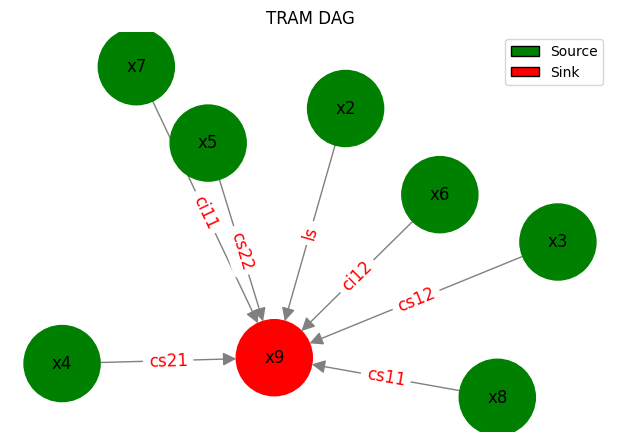

In [6]:
data_type = {'x2': 'cont','x3': 'cont','x4': 'cont','x5': 'cont','x6': 'cont','x7': 'cont','x8': 'cont','x9': 'cont'}
adj_matrix = np.array([
    ["0",  "0",  "0",  "0", "0",  "0",  "0",  "ls"],   # x1 → x2 (ci), x1 → x3 (ls)
    ["0",  "0",  "0",  "0", "0",  "0",  "0",  "cs12"],
    ["0",  "0",  "0",  "0", "0",  "0",  "0",  "cs21"],
    ["0",  "0",  "0",  "0", "0",  "0",  "0",  "cs22"],
    ["0",  "0",  "0",  "0", "0",  "0",  "0",  "ci12"],
    ["0",  "0",  "0",  "0", "0",  "0",  "0",  "ci11"],
    ["0",  "0",  "0",  "0", "0",  "0",  "0",  "cs11"],
    ["0",  "0",  "0",  "0", "0",  "0",  "0",  "0"]
], dtype=object)

plot_seed = 42
plot_dag(adj_matrix, data_type, seed=plot_seed)

*************
 Model has Complex intercepts and Complex shifts, please add your Model to the modelzoo 
*************


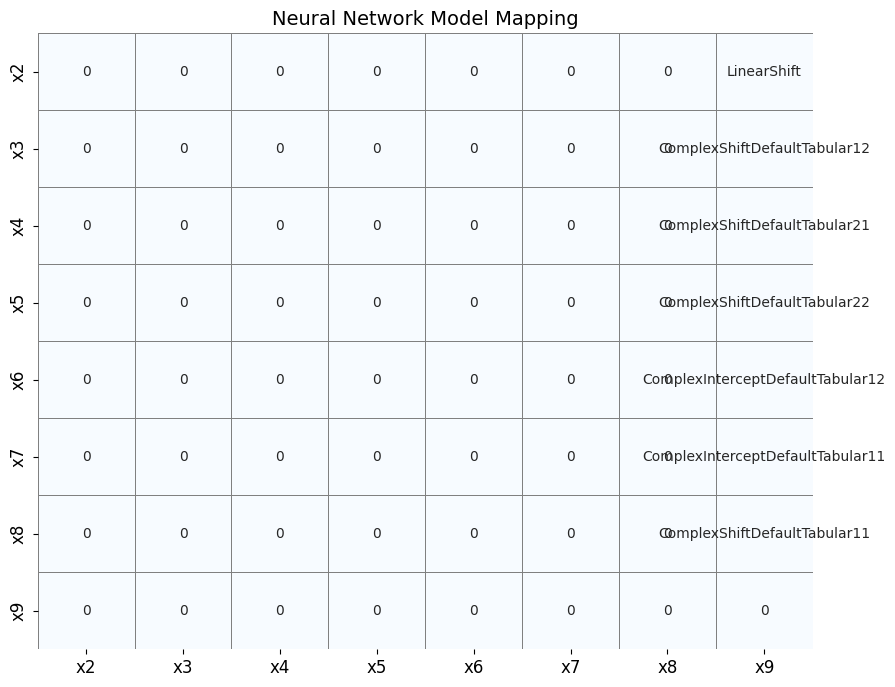

In [7]:
# check if there are Ci or Compelx shifts in the models. If yes define the modelnames
nn_names_matrix= create_nn_model_names(adj_matrix,data_type)
plot_nn_names_matrix(nn_names_matrix,data_type)

In [8]:
conf_dict=get_configuration_dict(adj_matrix,nn_names_matrix, data_type)
# write min max to conf dict
for i,node in enumerate(data_type.keys()):
    conf_dict[node]['min']=min_vals[i].tolist()
    conf_dict[node]['max']=max_vals[i].tolist()

conf_dict

{'x2': {'Modelnr': 0,
  'data_type': 'cont',
  'node_type': 'source',
  'parents': [],
  'parents_datatype': {},
  'transformation_terms_in_h()': {},
  'transformation_term_nn_models_in_h()': {},
  'min': 0.20000000298023224,
  'max': 0.20000000298023224},
 'x3': {'Modelnr': 1,
  'data_type': 'cont',
  'node_type': 'source',
  'parents': [],
  'parents_datatype': {},
  'transformation_terms_in_h()': {},
  'transformation_term_nn_models_in_h()': {},
  'min': 0.30000001192092896,
  'max': 0.30000001192092896},
 'x4': {'Modelnr': 2,
  'data_type': 'cont',
  'node_type': 'source',
  'parents': [],
  'parents_datatype': {},
  'transformation_terms_in_h()': {},
  'transformation_term_nn_models_in_h()': {},
  'min': 0.4000000059604645,
  'max': 0.4000000059604645},
 'x5': {'Modelnr': 3,
  'data_type': 'cont',
  'node_type': 'source',
  'parents': [],
  'parents_datatype': {},
  'transformation_terms_in_h()': {},
  'transformation_term_nn_models_in_h()': {},
  'min': 0.5,
  'max': 0.5},
 'x6':

In [9]:
DEV_TRAINING=True
train_list=['x2','x3','x4','x5','x6','x7','x8','x9']#['x1']#['x1','x2','x3']#,#,['x1','x2','x3'] # <-  set the nodes which have to be trained , useful if further training is required else lsit all vars

batch_size = 10
epochs = 2   # <- if you want a higher numbe rof epochs, set the number higher and it loads the old model and starts from there
use_scheduler = False

In [10]:
# For each NODE 
for node in conf_dict:

    print(f'\n----*----------*-------------*--------------- Node: {node} ------------*-----------------*-------------------*--')

    ########################## 0. Skip nodes ###############################
    if node not in train_list:
        print(f"Skipping node {node} as it's not in the training list.")
        continue
    if (conf_dict[node]['node_type'] == 'source') and (conf_dict[node]['node_type'] == 'other'):
        print(f"Node type : other , is not supported yet")
        continue

    ########################## 1. Create Model ##############################
    tram_model = get_fully_specified_tram_model(node, conf_dict, verbose=True).to(device)

    ########################## 2. Create Dataloaders ########################
    train_loader, val_loader = get_dataloader(node, conf_dict, train_df, val_df, batch_size=batch_size, verbose=True)

    # transformation terms in the correct order
    _, ordered_transformation_terms_in_h, _=ordered_parents(node, conf_dict)
    
    ########################## 3. Min/Max Tensor ############################
    min_vals = torch.tensor(conf_dict[node]['min'], dtype=torch.float32).to(device)
    max_vals = torch.tensor(conf_dict[node]['max'], dtype=torch.float32).to(device)
    min_max = torch.stack([min_vals, max_vals], dim=0)

    ########################## 4. Optimizer & Scheduler #####################
    optimizer = torch.optim.Adam(tram_model.parameters(), lr=0.01)

    if use_scheduler:
        scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0=10, T_mult=2)
    else:
        scheduler = None

    ########################## 5. Train for One Epoch #######################
    tram_model.train()
    total_train_loss = 0.0
    for x, y in train_loader:
        optimizer.zero_grad()
        y = y.to(device)
        int_input, shift_list = preprocess_inputs(x,ordered_transformation_terms_in_h.values(), device=device)
        y_pred = tram_model(int_input=int_input, shift_input=shift_list)
        loss = contram_nll(y_pred, y, min_max=min_max)
        loss.backward()
        optimizer.step()
        if use_scheduler:
            scheduler.step()
        total_train_loss += loss.item()
    avg_train_loss = total_train_loss / len(train_loader)
    print(f"[{node}] Training loss: {avg_train_loss:.4f}")

    ########################## 6. Validate for One Epoch ####################
    tram_model.eval()
    total_val_loss = 0.0
    with torch.no_grad():
        for x, y in val_loader:
            y = y.to(device)
            int_input, shift_list = preprocess_inputs(x, ordered_transformation_terms_in_h.values(), device=device)
            y_pred = tram_model(int_input=int_input, shift_input=shift_list)
            loss = contram_nll(y_pred, y, min_max=min_max)
            total_val_loss += loss.item()
    avg_val_loss = total_val_loss / len(val_loader)
    print(f"[{node}] Validation loss: {avg_val_loss:.4f}")



----*----------*-------------*--------------- Node: x2 ------------*-----------------*-------------------*--
>>>>>>>>>>>>  source node --> only  modelled only  by si
TramModel(
  (nn_int): SimpleIntercept(
    (fc): Linear(in_features=1, out_features=20, bias=False)
  )
)
>>>>>>>>>>>>  source node --> x in dataloader contains just 1s 
[x2] Training loss: nan
[x2] Validation loss: nan

----*----------*-------------*--------------- Node: x3 ------------*-----------------*-------------------*--
>>>>>>>>>>>>  source node --> only  modelled only  by si
TramModel(
  (nn_int): SimpleIntercept(
    (fc): Linear(in_features=1, out_features=20, bias=False)
  )
)
>>>>>>>>>>>>  source node --> x in dataloader contains just 1s 
[x3] Training loss: nan
[x3] Validation loss: nan

----*----------*-------------*--------------- Node: x4 ------------*-----------------*-------------------*--
>>>>>>>>>>>>  source node --> only  modelled only  by si
TramModel(
  (nn_int): SimpleIntercept(
    (fc): Linear(